# ✅ Quiz 1 — Solución 




## 1) Carga de imagen y preparación


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = r"C:\Users\rrm21\Documents\Vision_en_Robotica\imagenes\lenna.png"

img_bgr = cv2.imread(IMG_PATH)
if img_bgr is None:
    raise FileNotFoundError("⚠️ No se pudo cargar la imagen; revisa la ruta IMG_PATH.")

img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

h, w = img_rgb.shape[:2]
cx, cy = (w-1)/2.0, (h-1)/2.0

print("Tamaño:", (w, h))


Tamaño: (512, 512)


## 2) Visualización RGB vs Grises


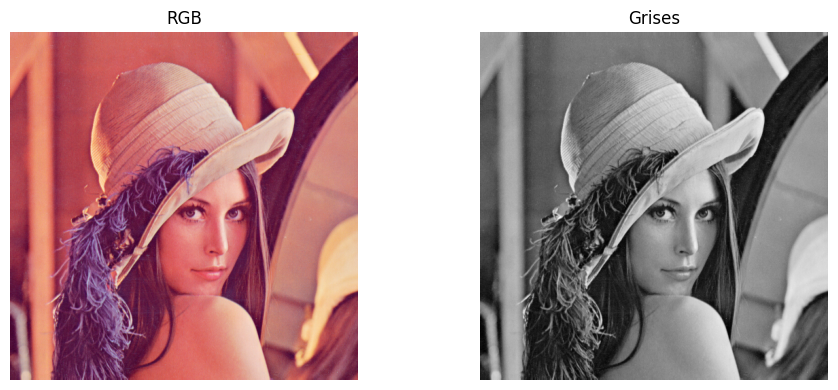

In [3]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_rgb); plt.title("RGB"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img_gray, cmap="gray"); plt.title("Grises"); plt.axis("off")
plt.tight_layout(); plt.show()

## 3) Histograma en escala de grises


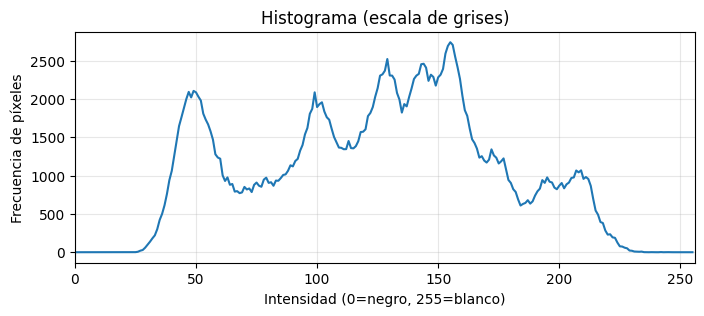

In [4]:
hist = cv2.calcHist([img_gray],[0],None,[256],[0,256])

plt.figure(figsize=(8,3))
plt.plot(hist); plt.xlim([0,256])
plt.title("Histograma (escala de grises)")
plt.xlabel("Intensidad (0=negro, 255=blanco)")
plt.ylabel("Frecuencia de píxeles")
plt.grid(alpha=0.3)
plt.show()

**Interpretación (guía):**  
- La distribución suele concentrarse en **tonos medios**, con contribuciones en sombras y altas luces.  
- Si el histograma estuviera muy a la izquierda → imagen **oscura**; a la derecha → **sobreexpuesta**; muy estrecho → **bajo contraste**.  
- En **robótica**, el histograma informa decisiones de **preprocesamiento** (exposición, normalización, ajuste de contraste) que afectan la detección de bordes y *features*.


## 4) Utilidad de visualización
Función auxiliar para mostrar resultados en **cuadrícula**.


In [5]:
def show_grid(images, titles, cols=3, figsize=(14,8)):
    import numpy as np
    import matplotlib.pyplot as plt
    rows = int(np.ceil(len(images)/cols))
    plt.figure(figsize=figsize)
    for i,(im,tt) in enumerate(zip(images, titles), 1):
        plt.subplot(rows, cols, i)
        if im.ndim == 2:
            plt.imshow(im, cmap="gray")
        else:
            plt.imshow(im)
        plt.title(tt); plt.axis("off")
    plt.tight_layout(); plt.show()

## 5) Transformaciones geométricas
Aplicamos **escalado**, **traslación**, **rotación (sin recorte)**, **afín** y **proyectiva**.


### 5.1 Escalado al 50%
Usamos `cv2.resize` con `fx=fy=0.5`. Útil para acelerar pipelines o normalizar tamaños de entrada.


In [6]:
scaled = cv2.resize(img_rgb, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
scaled_vis = cv2.resize(scaled, (w, h), interpolation=cv2.INTER_NEAREST)

### 5.2 Traslación (+40, +20)
Matriz afín 2×3 con desplazamientos \(t_x=40\), \(t_y=20\).


In [7]:
M_t = np.float32([[1,0,40],
                  [0,1,20]])
translated = cv2.warpAffine(img_rgb, M_t, (w, h), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

### 5.3 Rotación 45° 


In [8]:
angle = 45.0
M_r = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
cos = abs(M_r[0,0]); sin = abs(M_r[0,1])
new_w = int(h * sin + w * cos)
new_h = int(h * cos + w * sin)
M_r[0,2] += (new_w/2.0) - cx
M_r[1,2] += (new_h/2.0) - cy
rot_no_crop = cv2.warpAffine(img_rgb, M_r, (new_w, new_h), flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
rot_vis = cv2.resize(rot_no_crop, (w, h), interpolation=cv2.INTER_AREA)

## Afín con 3 puntos — dos enfoques

**Modelo:**
$x' = a_{11}x+a_{12}y+t_x$, $y' = a_{21}x+a_{22}y+t_y$ (6 parámetros).

Con 3 pares de puntos no colineales → sistema de 6 ecuaciones, solución única.

### Enfoque A (OpenCV)
Usar `cv2.getAffineTransform(src3,dst3)`.

### Enfoque B (Manual)
1. $B=[P_2-P_1, P_3-P_1]$, $B'=[P_2'-P_1', P_3'-P_1']$.
2. $A=B'B^{-1}$.
3. $t=P_1'-A P_1$.
4. Matriz completa: $M=[A|t]$.

In [9]:
src3 = np.float32([[0.2*w,0.3*h],[0.8*w,0.3*h],[0.3*w,0.8*h]])
dst3 = np.float32([[0.25*w,0.25*h],[0.75*w,0.35*h],[0.35*w,0.85*h]])

In [10]:
M_aff_cv = cv2.getAffineTransform(src3,dst3)
aff_cv = cv2.warpAffine(img_rgb,M_aff_cv,(w,h))
print('M (cv2):\n',M_aff_cv)

M (cv2):
 [[ 8.33333321e-01  3.33333090e-02  3.75466702e+01]
 [ 1.66666654e-01  1.16666671e+00 -6.82666800e+01]]


In [11]:
P1,P2,P3=src3.astype(float)
P1p,P2p,P3p=dst3.astype(float)
B=np.column_stack([(P2-P1),(P3-P1)])
Bp=np.column_stack([(P2p-P1p),(P3p-P1p)])
detB=np.linalg.det(B)
if abs(detB)<1e-12: raise ValueError('Colineales → no única')
A=Bp@np.linalg.inv(B)
t=P1p-A@P1
M_aff_manual=np.hstack([A,t.reshape(2,1)]).astype(np.float32)
aff_manual=cv2.warpAffine(img_rgb,M_aff_manual,(w,h))
print('M (manual):\n',M_aff_manual)

M (manual):
 [[ 8.3333331e-01  3.3333309e-02  3.7546669e+01]
 [ 1.6666666e-01  1.1666667e+00 -6.8266678e+01]]


Error RMS entre matrices: 1.0085106186051052e-06


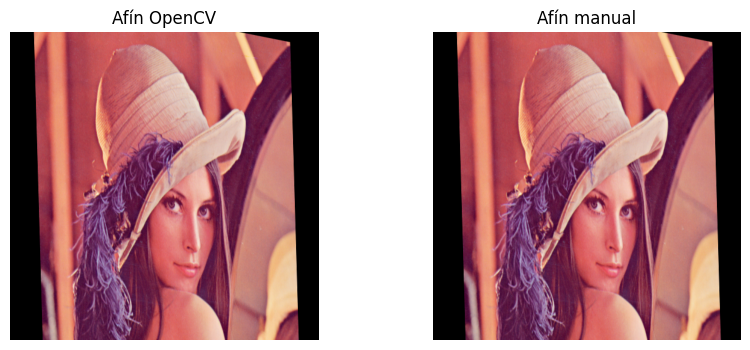

In [12]:
rms=np.sqrt(np.mean((M_aff_cv-M_aff_manual)**2))
print('Error RMS entre matrices:',rms)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1);plt.imshow(aff_cv);plt.title('Afín OpenCV');plt.axis('off')
plt.subplot(1,2,2);plt.imshow(aff_manual);plt.title('Afín manual');plt.axis('off')
plt.show()

### 5.5 Transformación Proyectiva (Homografía — 4 puntos)
Cuadrilátero interno a rectángulo destino con `getPerspectiveTransform + warpPerspective`.


In [13]:
src4 = np.float32([
    [0.30*w, 0.30*h],
    [0.70*w, 0.28*h],
    [0.75*w, 0.70*h],
    [0.28*w, 0.72*h],
])
Wout, Hout = 400, 400
dst4 = np.float32([
    [0,0],
    [Wout-1,0],
    [Wout-1,Hout-1],
    [0,Hout-1],
])
H = cv2.getPerspectiveTransform(src4, dst4)
proj = cv2.warpPerspective(img_rgb, H, (Wout, Hout), flags=cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
proj_vis = cv2.resize(proj, (w, h), interpolation=cv2.INTER_AREA)

## 6) Visualización comparativa (cuadrícula 2×3)
Incluimos la **original** y todas las transformaciones calculadas.


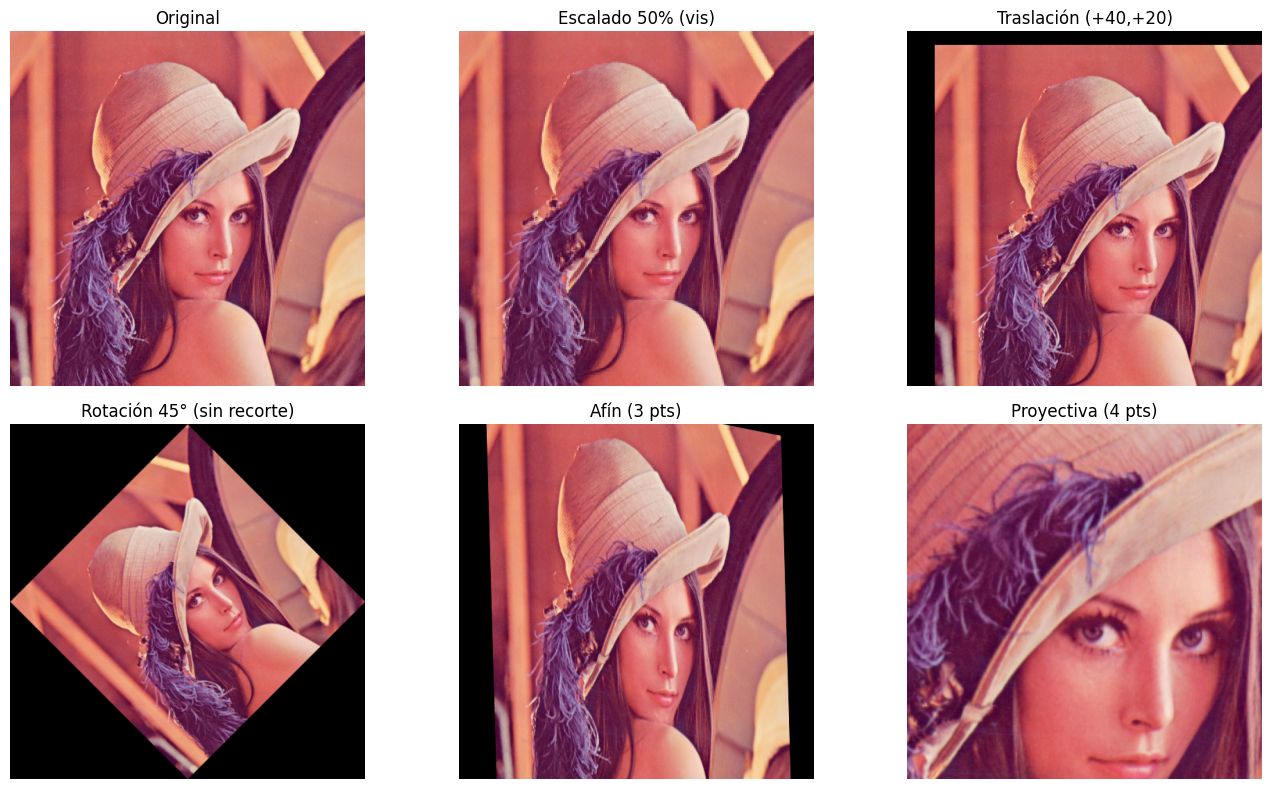

In [14]:
grid_imgs = [img_rgb, scaled_vis, translated, rot_vis, aff_cv, proj_vis]
grid_titles = ["Original", "Escalado 50% (vis)",
               "Traslación (+40,+20)", "Rotación 45° (sin recorte)",
               "Afín (3 pts)", "Proyectiva (4 pts)"]

show_grid(grid_imgs, grid_titles, cols=3, figsize=(14,8))

## 7) Aplicaciones en robótica (guía de respuesta)
- **Escalado:** acelerar procesamiento en tiempo real; normalizar resolución para redes o módulos de visión.  
- **Rotación:** compensar inclinación (IMU), *deskew* de objetos/etiquetas previo a OCR o mediciones.  
- **Afín:** normalizar pequeñas perspectivas en planos casi paralelos (transportadoras, mesas de ensamblaje).  
- **Proyectiva (homografía):** vista **bird’s‑eye** del piso para seguimiento de carriles; rectificación de documentos o tableros para medición.  
